# Gaussian Process

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from itertools import permutations

## Part 1.
Apply Gaussian Process Regression to predict the distribution of f
and visualize the result. Please use a rational quadratic kernel to compute
similarities between different points.

In [2]:
def load_data(data_path):
    X = []
    y = []
    with open(data_path, 'r') as f:
        for line in f.readlines():
            line = line.split()
            X.append(float(line[0]))
            y.append(float(line[1]))

    return np.array(X), np.array(y)

### Rational Quadratic Kernel
<div align="center">
<img src="./img/rational_quadratic_kernel.png" width = "400" alt="rational quadratic kernel" align=center />
</div>

In [3]:
def rational_quadratic_kernel(x_a, x_b, **kernel_param):
    sigma = kernel_param.get('sigma', 1.0)
    length_scale = kernel_param.get('length_scale', 1.0)
    alpha = kernel_param.get('alpha', 1.0)
    SE = np.power(x_a.reshape(-1, 1) - x_b.reshape(1, -1), 2)
    return (sigma ** 2) * np.power(1 + SE / (2 * alpha * length_scale), -alpha)

### Prediction 

<div align="center">
<img src="./img/covariance.png" width = "500" alt="covariance" align=center />
</div>

In [4]:
def covariance(X, kernel_func, *, beta=5, **kernel_param):
    return kernel_func(X, X, **kernel_param) + 1 / beta * np.identity(len(X))

<div align="center">
<img src="./img/gaussian_process.png" width = "600" alt="gaussian process prediction" align=center />
</div>

In [5]:
def predict(X, x_star, y, kernel_func, *, beta=5, **kernel_param):
    k_x_s = kernel_func(X, x_star, **kernel_param)
    k_star = kernel_func(x_star, x_star, **kernel_param) + 1 / beta * np.identity(len(x_star))
    C = covariance(X, kernel_func, beta=beta, **kernel_param)
    temp = k_x_s.T @ np.linalg.inv(C)   
    mean =  temp @ y
    var = k_star - temp @ k_x_s

    return mean, var

In [6]:
X_train, y_train = load_data("./data/input.data")
X_test = np.linspace(-60, 60, num=500)

In [7]:
mean, var = predict(X_train, X_test, y_train, rational_quadratic_kernel)

### Visualization

In [8]:
def visualization(X, y, x_star, mean, std):
    plt.figure(figsize=(20, 5))
    plt.plot(x_star, mean, color='lightseagreen', label='mean')
    plt.fill_between(x_star, mean + 2 * std, mean - 2 * std, facecolor='aquamarine', label='95% confidence interval')
    plt.scatter(X, y, color='mediumvioletred', label='data')
    plt.legend(loc='upper right')
    plt.show()

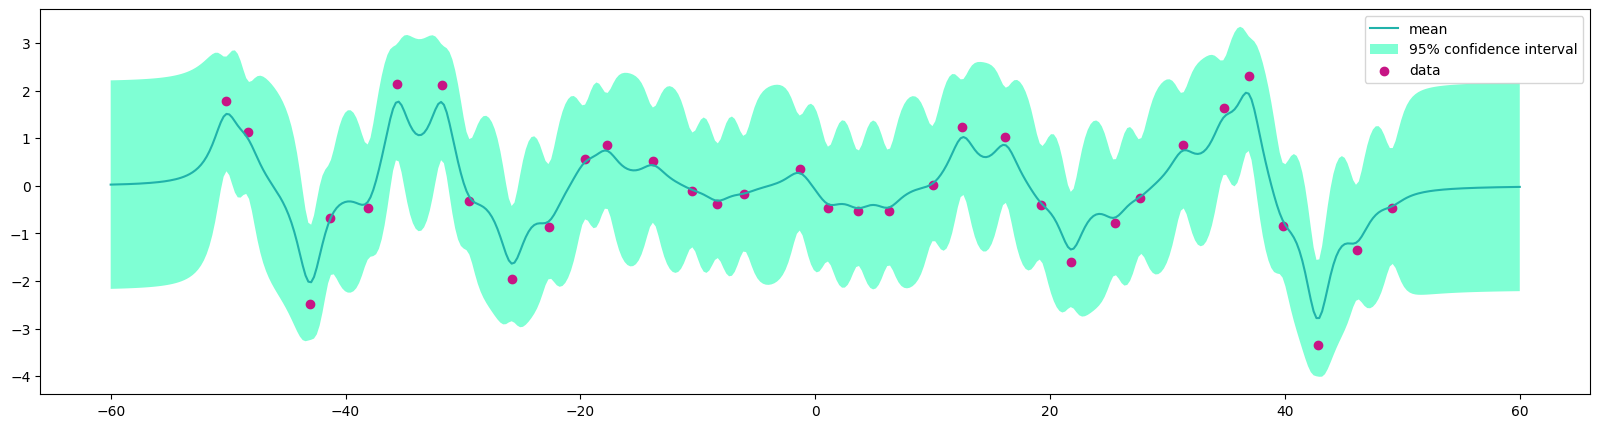

In [9]:
std = np.sqrt(np.diag(var))
visualization(X_train, y_train, X_test, mean, std)

## Part 2.  
Optimize the kernel parameters by minimizing negative marginal log-likelihood, and visualize the result again. 


### Marginal log likelihood
<div align="center">
<img src="./img/log_likelihood.png" width = "700" alt="log likelihoos" align="center" />
</div>

In [10]:
def obj_func(const_args):
    X, y, beta = const_args
    def negLogLikelihood(x0):
        kernel_param = {"sigma": x0[0], "length_scale": x0[1], "alpha": x0[2]}
        C = covariance(X, rational_quadratic_kernel, beta=beta, **kernel_param)
        return 0.5 * np.log(np.linalg.det(C)) + 0.5 * y.T @ np.linalg.inv(C) @ y + len(X) / 2 * np.log(2 * np.pi)
    return negLogLikelihood

### Minimize negative marginal log likelihood to get optimal kernel parameters

In [12]:
init = [0.01, 0.1, 1, 10]
const_args = (X_train, y_train, 5)
bounds = ((1e-6, 1e6), (1e-6, 1e6), (1e-6, 1e6))
obj_opt = 1e9

for sigma, length_scale, alpha in permutations(init, 3):
    x0 = np.asarray((sigma, length_scale, alpha))
    res = minimize(obj_func(const_args), x0, bounds=bounds)
    if res.fun < obj_opt:
        obj_opt = res.fun
        x_opt = res.x

print(f"Optimal objective function value: {obj_opt}")
print(f"Optimal sigma value: {x_opt[0]}")
print(f"Optimal length scale value: {x_opt[1]}")
print(f"Optimal alpha value: {x_opt[2]}")

Optimal objective function value: 50.67411232130118
Optimal sigma value: 1.3088196261852434
Optimal length scale value: 10.983375843905543
Optimal alpha value: 2074.7350068145447


### Prediction & Visualization

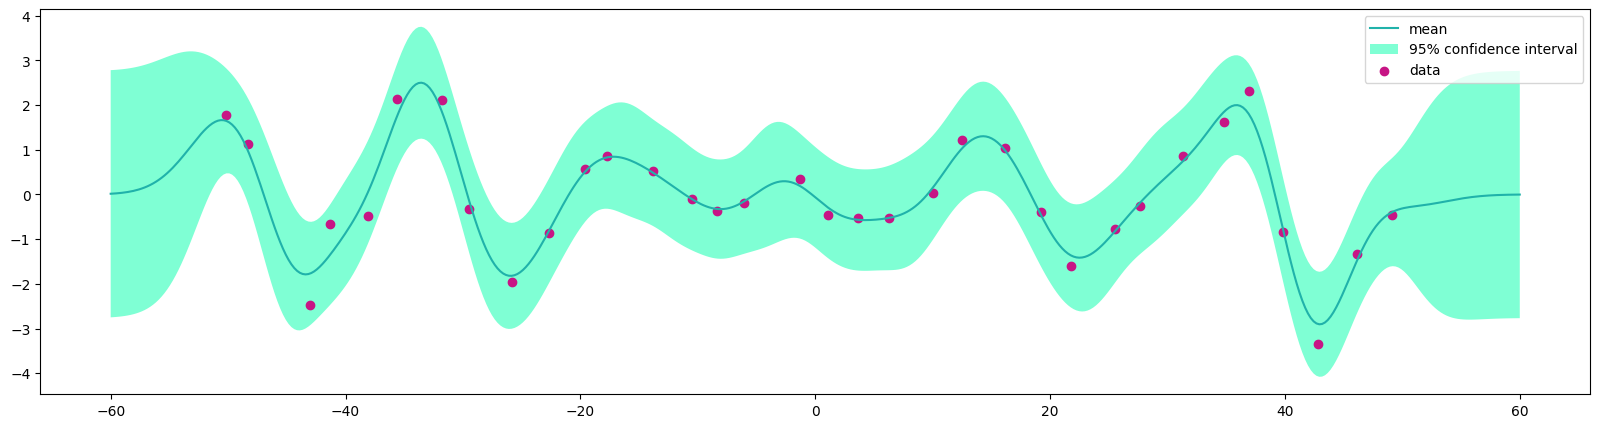

In [13]:
kernel_param = {'sigma': x_opt[0], 'length_scale': x_opt[1], 'alpha': x_opt[2]}
mean_opt, var_opt = predict(X_train, X_test, y_train, rational_quadratic_kernel, **kernel_param)
std_opt = np.sqrt(np.diag(var_opt))
visualization(X_train, y_train, X_test, mean_opt, std_opt)